In [57]:
import subprocess as sp
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns  # for aesthetic

import neuraltda.topology2 as tp2
import neuraltda.spectralAnalysis as sa
import neuraltda.simpComp as sc
import numpy as np
import tempfile
import h5py as h5
import glob
import os
from importlib import reload
import tqdm
%matplotlib inline

sns.set_style('ticks')

import datetime
daystr = datetime.datetime.now().strftime('%Y%m%d')
figsavepth = '/home/brad/DailyLog/'+daystr+'/'
print(figsavepth)

/home/brad/DailyLog/20170912/


In [58]:
winsize = 10.0
segment_info = [0, 0]
pover = 0.5
block_path = '/home/brad/krista/B1083/P03S03/'
#block_path = '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site05_Z3500__B1056_cat_P01_S05_1/'
#block_path = '/home/brad/krista/B1235/P02S01/'
# Bin data
bfdict = tp2.dag_bin(block_path, winsize, segment_info, cluster_group=['Good'], dt_overlap=pover*winsize, comment='ForSCM')
bdf = glob.glob(os.path.join(bfdict['raw'], '*.binned'))[0]
print(bdf)

/home/brad/krista/B1083/P03S03/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForSCM/20170829T191155Z-10.0-5.0.binned


In [59]:
thresh = 13.0


nperms=None
ncellsperm=0
dims = [0,1,2,3]
twin = np.linspace(0, 6000, 100)
windt = winsize
dtovr=pover*windt

stim_dict = {}
stim_shuffled_dict = {}
stim_scm_dict = {}
stim_betticurve_dict = {}
stim_shuffled_betticurve_dict = {}

In [60]:
reload(tp2)
# compute real and shuffled betti curves - TrialAverage
print('Computing trial average')
(bc_tavg, t, tms) = tp2.compute_trialaverage_betti_curves('ForSCMControl', block_path, bdf, thresh, nperms, ncellsperm, dims, twin, windt, dtovr)
(bc_tavg_shuff, t, tms) = tp2.compute_trialaverage_betti_curves('ForSCMControl-Shuffle', block_path, bdf, thresh, nperms, ncellsperm, dims, twin, windt, dtovr, shuffle=True)

Computing trial average


In [ ]:
bc['I_40k'].shape

In [ ]:
reload(tp2)
with h5.File(bdf, 'r') as bdff:
    stims = bdff.keys()
    for stim in stims:
        print(stim)
        stim_poptens = tp2.extract_population_tensor(bdf, stim)
        ntrials = tp2.num_trials(stim_poptens)
        stim_scm_dat= []
        for trial in tqdm.tqdm(range(ntrials)):
            scm_bettis = tp2.calc_scm_betti_distribution(stim_poptens, thresh, trial, nsamples)
        
            stim_scm_dat.append(scm_bettis)
        stim_scm_dict[stim] = stim_scm_dat

In [71]:
def plot_scm_distribution(scm_bettis, trial, bettinum, maxbin=200, ax=None, **kwargs):
    nmaxtot = 0
    scm_trial_bettis = scm_bettis[trial]
    bettivals = []
    try:
        for x in scm_trial_bettis:
            try:
                bettivals.append(x[0][bettinum])
            except IndexError:
                bettivals.append(0)
    except IndexError:
        bettivals = [x[bettinum] for x in scm_trial_bettis]
    bettivals2 = []
    for x in bettivals:
        if type(x) is not list:
            bettivals2.append(x)
        else:
            bettivals2.append(x[0])
    #print(bettivals)
    maxbettival = np.amax(bettivals2)
    maxbin = round(1.5*maxbettival)
    print(maxbin)
    bins = np.arange(maxbin)
    (n, bins2, ptaches) = ax.hist(bettivals2, bins, normed=True, stacked=True, **kwargs)
    #print(n)
    nmax = np.amax(n)
    nmaxtot = np.amax([nmax, nmaxtot])
    nmaxx = np.amax(bins)
    return (nmaxtot, nmaxx)

In [ ]:
# average over all trials
import tqdm
nsamples = 200

stim_dict = {}
stim_shuffled_dict = {}
stim_scm_dict = {}
stim_betticurve_dict = {}
stim_shuffled_betticurve_dict = {}
with h5.File(bdf, 'r') as bdff:
    stims = bdff.keys()
    for stim in tqdm.tqdm(stims):
        #print(stim)
        trial=0
        stim_poptens = tp2.extract_population_tensor(bdf, stim)
        ntrials = tp2.num_trials(stim_poptens)
        stim_scm_dat= []
        stim_trialavg_poptens = np.mean(stim_poptens, axis=2)[:, :, np.newaxis]     
        scm_bettis = tp2.calc_scm_betti_distribution(stim_trialavg_poptens, thresh, trial, nsamples)
        stim_scm_dict[stim] = scm_bettis


In [ ]:
import pickle
with open(os.path.join(block_path,'scm_control_save_trialvg_thresh13.pkl'), 'wb') as f:
    pickle.dump(stim_scm_dict, f)

In [62]:
import pickle
with open(os.path.join(block_path,'scm_control_save_trialvg.pkl'), 'rb') as f:
    stim_scm_dict = pickle.load(f)


In [ ]:
int([-1])

[ 5.83333333  0.          0.          0.          0.          0.
  0.66666667  0.          0.          0.          0.          0.          0.
  0.13333333  0.          0.          0.          0.          0.
  0.03333333]
[  2.  50.  72.   4.]
[ 19.6   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.4]
[  2.  58.  41.   3.]
[ 4.3    0.     0.     0.     0.     0.575  0.     0.     0.     0.     0.075
  0.     0.     0.     0.     0.025  0.     0.     0.     0.025]
[  3.  42.  42.   0.]


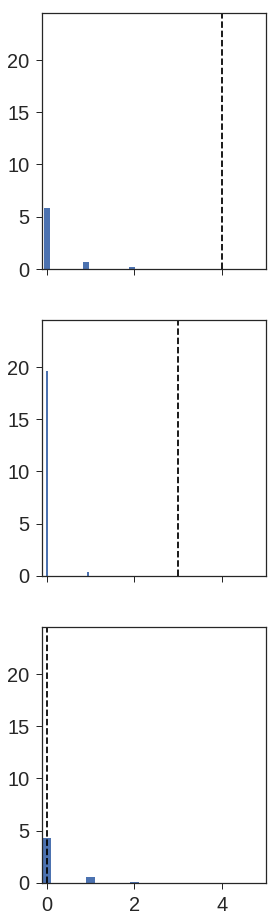

In [7]:
f, axs = plt.subplots(3, 1, sharey=True, sharex=True, figsize=(4, 16))
betti_num = 3
stims = list(bc_tavg.keys())[1:4]
my = 0
nmaxyt = 0
nmaxxt = 0
for ax, stim in zip(axs.flatten(), bc_tavg.keys()):
    final_bettis = bc_tavg[stim][:, -1, 0]
   
    #final_bettis = stim_betticurve_dict[stim][-1]
    b = final_bettis[betti_num]
    ax.plot([b, b], [0, 100], 'k--')
    (nmaxy, nmaxx) = plot_scm_distribution([stim_scm_dict[stim]], 0, betti_num, ax, align='left', histtype='stepfilled')
    nmaxyt = np.amax([nmaxy, nmaxyt])
    nmaxxt = np.amax([nmaxx, nmaxxt])
    print(final_bettis)

    #ax.set_title(stim)
    
    ax.set_xlim([-0.1, 1.25*nmaxxt])
    ax.set_ylim([0, 1.25*nmaxyt])
    ax.tick_params(labelsize=20)
plt.savefig(os.path.join(figsavepth, 'SCMControlB1083_betti{}.eps'.format(betti_num)))

3.0
[  2.  50.  72.   4.]
4.0
[  2.  58.  41.   3.]
4.0
[  3.  42.  42.   0.]
111.0
[  2.  50.  72.   4.]
141.0
[  2.  58.  41.   3.]
99.0
[  3.  42.  42.   0.]
310.0
[  2.  50.  72.   4.]
201.0
[  2.  58.  41.   3.]
308.0
[  3.  42.  42.   0.]
4.0
[  2.  50.  72.   4.]
2.0
[  2.  58.  41.   3.]
6.0
[  3.  42.  42.   0.]


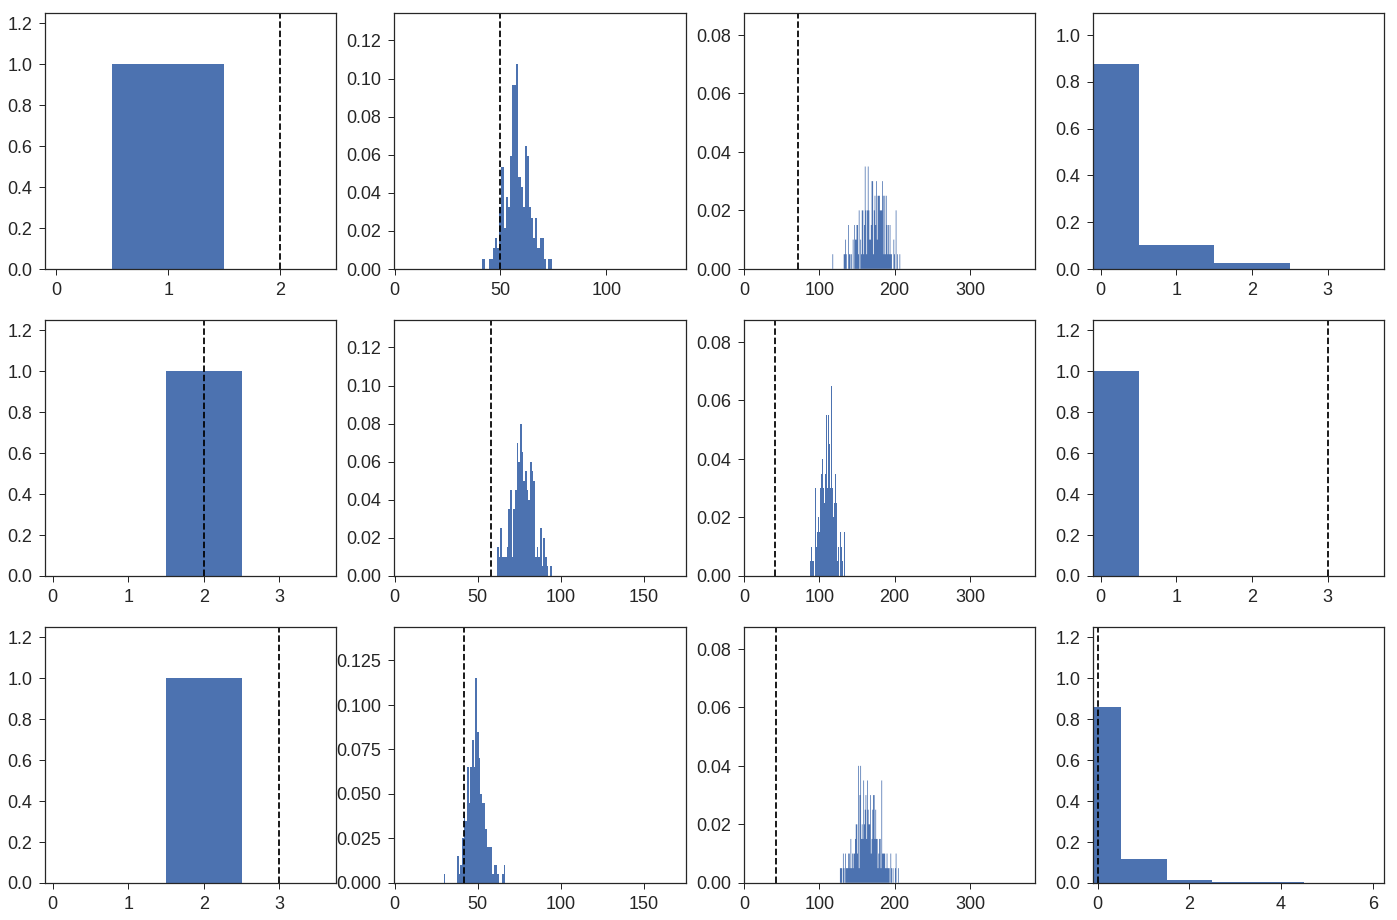

In [72]:
f, axs = plt.subplots(3, 4,figsize=(24, 16))
betti_num = 3
bettis = [0,1,2,3]
stims = list(bc_tavg.keys())[1:4]
my = 0
for betti_num in bettis:
    nmaxyt = 0
    nmaxxt = 0
    bettiax = axs.flatten()[4*np.array([0,1,2]) + betti_num]
    for ax, stim in zip(bettiax, bc_tavg.keys()):
        final_bettis = bc_tavg[stim][:, -1, 0]
   
        #final_bettis = stim_betticurve_dict[stim][-1]
        b = final_bettis[betti_num]
        ax.plot([b, b], [0, 100], 'k--')
        (nmaxy, nmaxx) = plot_scm_distribution([stim_scm_dict[stim]], 0, betti_num, ax=ax, align='left', histtype='stepfilled')
        nmaxyt = np.amax([nmaxy, nmaxyt])
        nmaxxt = np.amax([nmaxx, nmaxxt])
        print(final_bettis)

    #ax.set_title(stim)
    
        ax.set_xlim([-0.1, 1.25*nmaxxt])
        ax.set_ylim([0, 1.25*nmaxyt])
        ax.tick_params(labelsize=18)
plt.savefig(os.path.join(figsavepth, 'SCMControlB1083_bettiAll.eps'.format(betti_num)))

In [ ]:
#compute pvalues
dims2 = [0,1,2]
for stim in bc_tavg.keys():
    for dim in dims2:
        final_betti = bc_tavg[stim][dim, -1, 0]
        scm_dist = np.array(stim_scm_dict[stim])
        scm_dist = [x[0][dim] for x in scm_dist]
        m = np.mean(scm_dist)
        N = len(scm_dist)
        if final_betti > m:
        
            count = np.sum(np.greater(scm_dist, final_betti))
        else:
            count = np.sum(np.less(scm_dist, final_betti))
        p = 2*(1+count)/(N+1)
        print('Stim: {} dim: {}  pvalue: {}'.format(stim, dim, p))
    print('\n')
    

In [ ]:
np.mean(stim_scm_dict[stim][:, :, 1])

In [ ]:
stim_scm_dict[stim]

In [ ]:
np.array(stim_scm_dict[stim]).shape

In [ ]:
test = stim_scm_dict[stim]


In [ ]:
test

In [ ]:
with h5.File(bdf, 'r') as f:
    test_pt = np.array(f[list(f.keys())[1]]['pop_tens'])

In [ ]:
test_pt.shape

In [ ]:
trialavg = np.mean(test_pt, axis=2)

In [ ]:
avg_frs = np.mean(trialavg, axis=1)

In [ ]:
avg_frs.shape

In [ ]:
avg_frs